In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [15]:
# Veri setini yükleme
file_path = "veri/dataset_with_anomalies.csv"  # İşlenmiş CSV dosyası
df = pd.read_csv(file_path)

# Veri setinin genel bilgileri
print("Veri Seti Genel Bilgileri:")
print(df.info())

# Kategorik değişkenlerin encoding işlemi
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Özellik-hedef ayrımı: 'anomaly' hedef değişken olarak kullanılıyor
X = df.drop(columns=['anomaly'])  # 'anomaly' sütunu dışında kalan tüm sütunlar
y = df['anomaly']  # 'anomaly' hedef değişken

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Özelliklerin standardize edilmesi
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor dönüşümü
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


Veri Seti Genel Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69865 entries, 0 to 69864
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  69865 non-null  float64
 1   host_name             69865 non-null  float64
 2   latitude              69865 non-null  float64
 3   longitude             69865 non-null  float64
 4   host_since            69865 non-null  float64
 5   host_location         69865 non-null  float64
 6   host_acceptance_rate  69865 non-null  float64
 7   property_type         69865 non-null  float64
 8   room_type             69865 non-null  float64
 9   price                 69865 non-null  float64
 10  minimum_nights        69865 non-null  float64
 11  maximum_nights        69865 non-null  float64
 12  availability_30       69865 non-null  float64
 13  availability_365      69865 non-null  float64
 14  number_of_reviews     69865 non-null  float

In [16]:
# DataLoader oluşturma
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# Model tanımı
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

# Modelin örneklenmesi
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
print(model)


NeuralNetwork(
  (layer1): Linear(in_features=16, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


In [18]:
# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Eğitim
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))
    
    # Doğrulama
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")


Epoch 1/20, Training Loss: 0.1302, Validation Loss: 0.0971
Epoch 2/20, Training Loss: 0.0925, Validation Loss: 0.0849
Epoch 3/20, Training Loss: 0.0848, Validation Loss: 0.0777
Epoch 4/20, Training Loss: 0.0789, Validation Loss: 0.0766
Epoch 5/20, Training Loss: 0.0762, Validation Loss: 0.0738
Epoch 6/20, Training Loss: 0.0735, Validation Loss: 0.0718
Epoch 7/20, Training Loss: 0.0714, Validation Loss: 0.0680
Epoch 8/20, Training Loss: 0.0695, Validation Loss: 0.0719
Epoch 9/20, Training Loss: 0.0679, Validation Loss: 0.0641
Epoch 10/20, Training Loss: 0.0669, Validation Loss: 0.0667
Epoch 11/20, Training Loss: 0.0646, Validation Loss: 0.0660
Epoch 12/20, Training Loss: 0.0657, Validation Loss: 0.0634
Epoch 13/20, Training Loss: 0.0640, Validation Loss: 0.0628
Epoch 14/20, Training Loss: 0.0626, Validation Loss: 0.0632
Epoch 15/20, Training Loss: 0.0620, Validation Loss: 0.0620
Epoch 16/20, Training Loss: 0.0619, Validation Loss: 0.0683
Epoch 17/20, Training Loss: 0.0606, Validation Lo

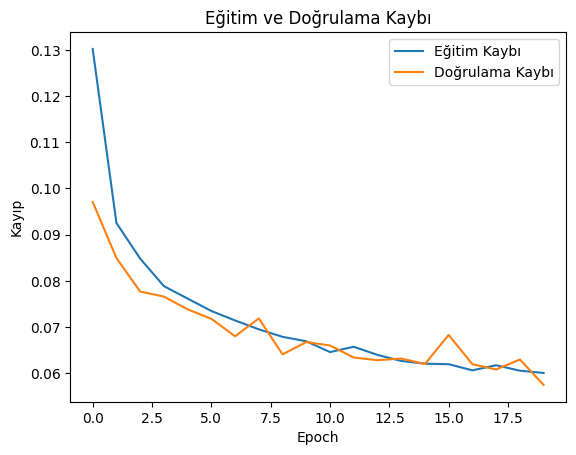


Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.66      0.75       729
           1       0.98      0.99      0.99     13244

    accuracy                           0.98     13973
   macro avg       0.92      0.83      0.87     13973
weighted avg       0.98      0.98      0.98     13973



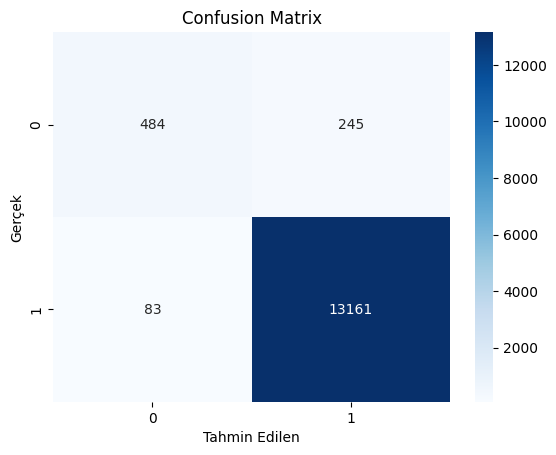

In [19]:
# Eğitim ve doğrulama kayıplarının grafiği
plt.plot(train_losses, label='Eğitim Kaybı')
plt.plot(val_losses, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Test setinde tahminler
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()

# Performans metrikleri
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()
